In [1]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm, trange
from utils import *
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Dropout Network

In [2]:
class Dropout_Network(nn.Module):
    def __init__(self, input_dim, output_dim, num_units, drop_prob):
        super(Dropout_Network, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.drop_prob = drop_prob
        
        self.layer1 = nn.Linear(input_dim, num_units)
        self.layer2 = nn.Linear(num_units, num_units)
        self.layer3 = nn.Linear(num_units, 2*output_dim)
        self.activation = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = x.view(-1, self.input_dim)
        
        x = self.layer1(x)
        x = self.activation(x)
        x = F.dropout(x, p=self.drop_prob, training=True,)
        
        x = self.layer2(x)
        x = self.activation(x)
        x = F.dropout(x, p=self.drop_prob, training=True)
        
        x = self.layer3(x)
        return x

## A Wrapper for Dropout Model

In [3]:
class Dropout_Model:
    def __init__(self, network, learn_rate, weight_decay, y_scale):
        self.learn_rate = learn_rate
        self.y_scale = y_scale
        self.network = network
        self.network.to(DEVICE)
        self.optimizer = torch.optim.SGD(self.network.parameters(), lr=learn_rate, weight_decay=weight_decay)
        
    def log_gaussian_loss(self,output, target, sigma, no_dim):
        exponent = -0.5*(target - output)**2/sigma**2
        log_coeff = -no_dim*torch.log(sigma) - 0.5*no_dim*np.log(2*np.pi)
        return - (log_coeff + exponent).sum()
    
    def fit(self, X, y):
        self.network.train()
        X, y = X.to(DEVICE), y.to(DEVICE)
        self.optimizer.zero_grad()
        output = self.network(X)
        loss = self.log_gaussian_loss(output[:, :1], y, output[:, 1:].exp(), 1)
        loss.backward()
        self.optimizer.step()
        return loss
    
    def predict(self, X, num_samples):
        if num_samples == 1:
            self.network.eval()
        else:
            self.network.train()
        X = X.to(DEVICE)
        pred_means, pred_stds = [], []        
        for i in range(num_samples):
            output = self.network(X)
            pred_mean = output[:, :1, None]
            pred_std = output[:, 1:, None].exp()
            pred_means.append(pred_mean)
            pred_stds.append(pred_std)        
        pred_means, pred_stds = torch.cat(pred_means, 2), torch.cat(pred_stds, 2)    
        mean = pred_means.mean(dim=2)
        std = (pred_means.var(dim=2) + pred_stds.mean(dim=2)**2)**0.5
        return mean, std 
    
    def evaluate(self, test_loader, num_samples, gamma):
        if gamma == 0.95:
            n_std_devs = 1.96
        elif gamma == 0.90:
            n_std_devs = 1.645
        elif gamma == 0.99:
            n_std_devs = 2.575
        else:
            raise Exception('ERROR unusual gamma')
        mean, std,features, target = [],[],[],[]
        for batch_idx, (X_test, y_test) in enumerate(test_loader):
            batch_mean, batch_std = self.predict(X_test, num_samples)
            mean.append(batch_mean)
            std.append(batch_std)
            features.append(X_test)
            target.append(y_test)
        mean = torch.cat(mean, dim=0)
        std = torch.cat(std, dim=0)
        features = torch.cat(features, dim=0)
        target = torch.cat(target, dim=0)   
        rmse=((mean - target)**2).mean()**0.5
        pred_U = mean+n_std_devs*(std)
        pred_L = mean-n_std_devs*(std)
        k_U = torch.max(torch.tensor(0.),torch.sign(pred_U - target))
        k_L = torch.max(torch.tensor(0.),torch.sign(target - pred_L))
        k= torch.mul(k_U, k_L)
        PICP= k.mean()
        MPIW =(pred_U-pred_L).mean()   
        rmse = float(rmse.cpu().data)*self.y_scale
        PICP = float(PICP.cpu().data)
        MPIW = float(MPIW.cpu().data)      
        return rmse, PICP, MPIW, mean, pred_U, pred_L, features, target 

## Hyper-parameters

In [4]:
BATCH_SIZE =128 
TEST_BATCH_SIZE = 128
TRAIN_EPOCHS = 150
NUM_SAMPLES_TRAIN = 20
NUM_SAMPLES_TEST= 1000
OUTPUT_DIM = 1
NUM_UNITS = 100
GAMMA = 0.95
drop_prob=0.1
learn_rate=1e-4
log_every=10
model_name='Dropout_LL'

## Boston Housing

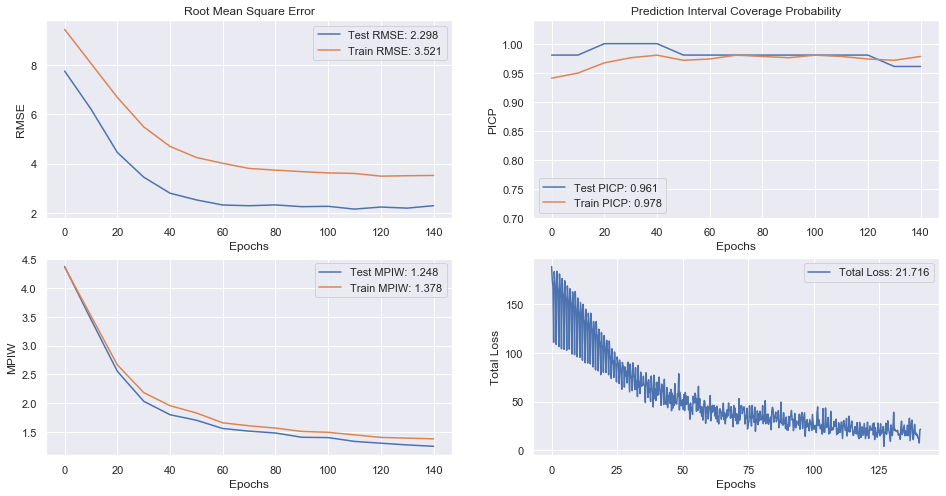

100%|██████████| 150/150 [00:16<00:00,  9.15it/s]


 RMSE = 2.282, PICP = 0.961, MPIW = 1.275


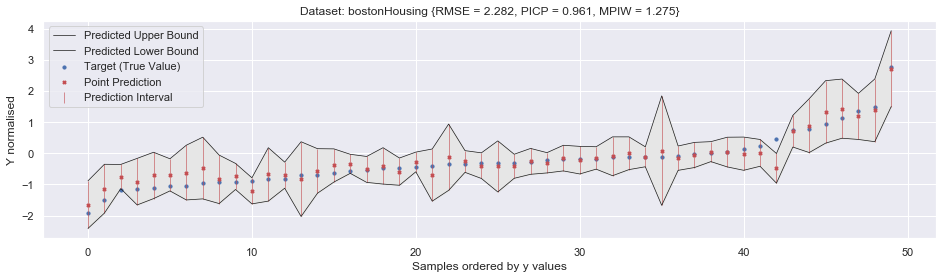

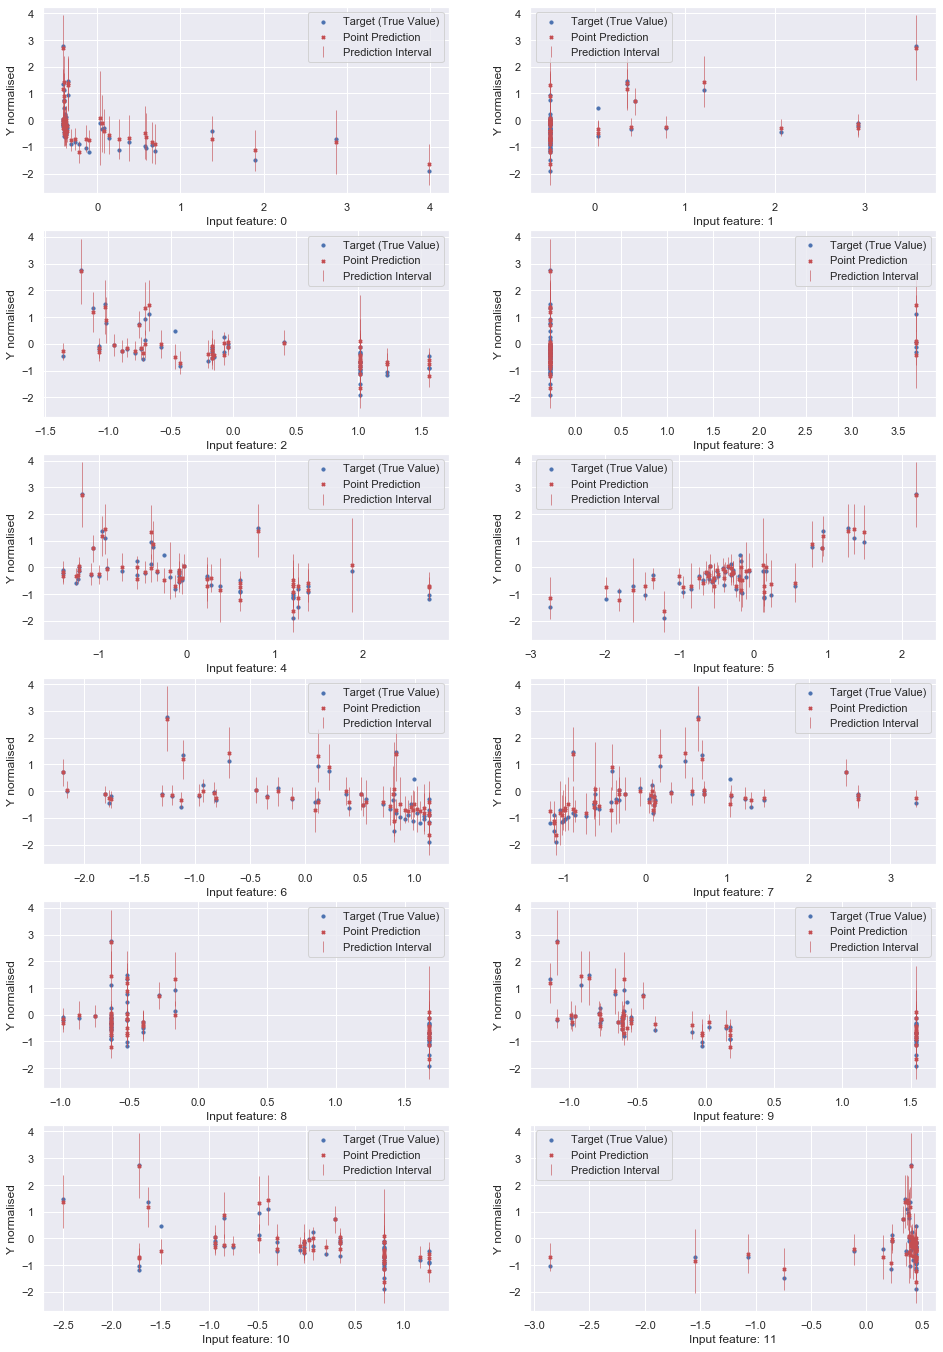

In [5]:
DATA_DIR="bostonHousing"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]
weight_decay=1e-1/(TRAIN_SIZE+TEST_SIZE)**0.5

bostonHousing_model= Dropout_Model(network=Dropout_Network(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS, 
                                             drop_prob=drop_prob),
                                   learn_rate=learn_rate, 
                                   weight_decay=weight_decay,
                                   y_scale=y_scale)

train_dropout(bostonHousing_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR,model_name)
evaluate_model(bostonHousing_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR,model_name)



## Concrete

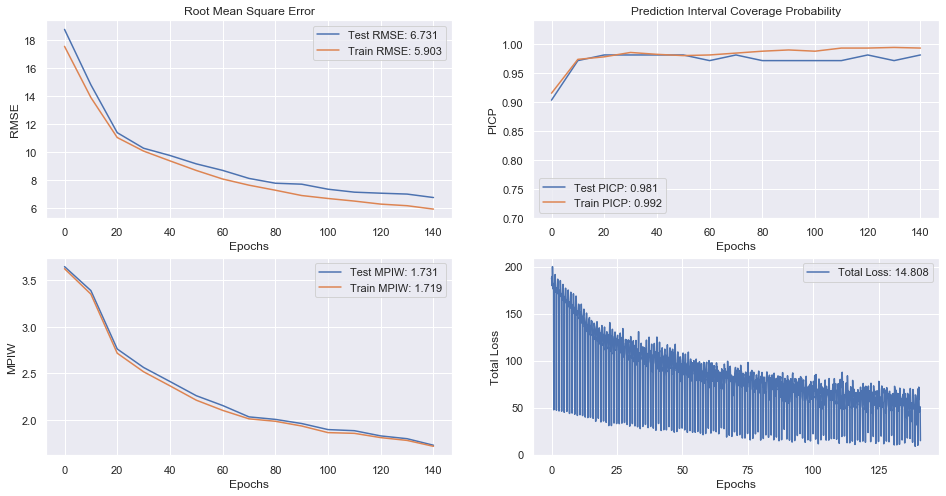

100%|██████████| 150/150 [00:18<00:00,  8.05it/s]


 RMSE = 6.598, PICP = 0.971, MPIW = 1.738


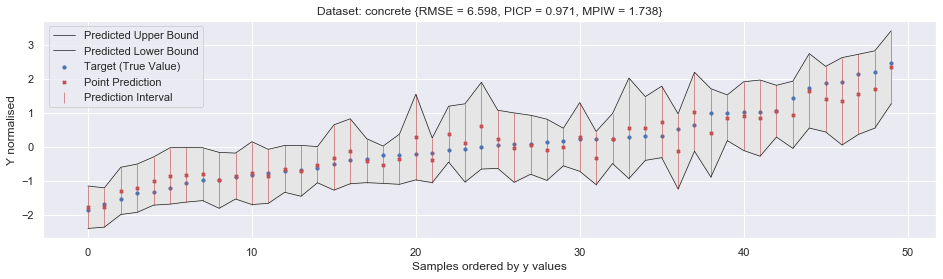

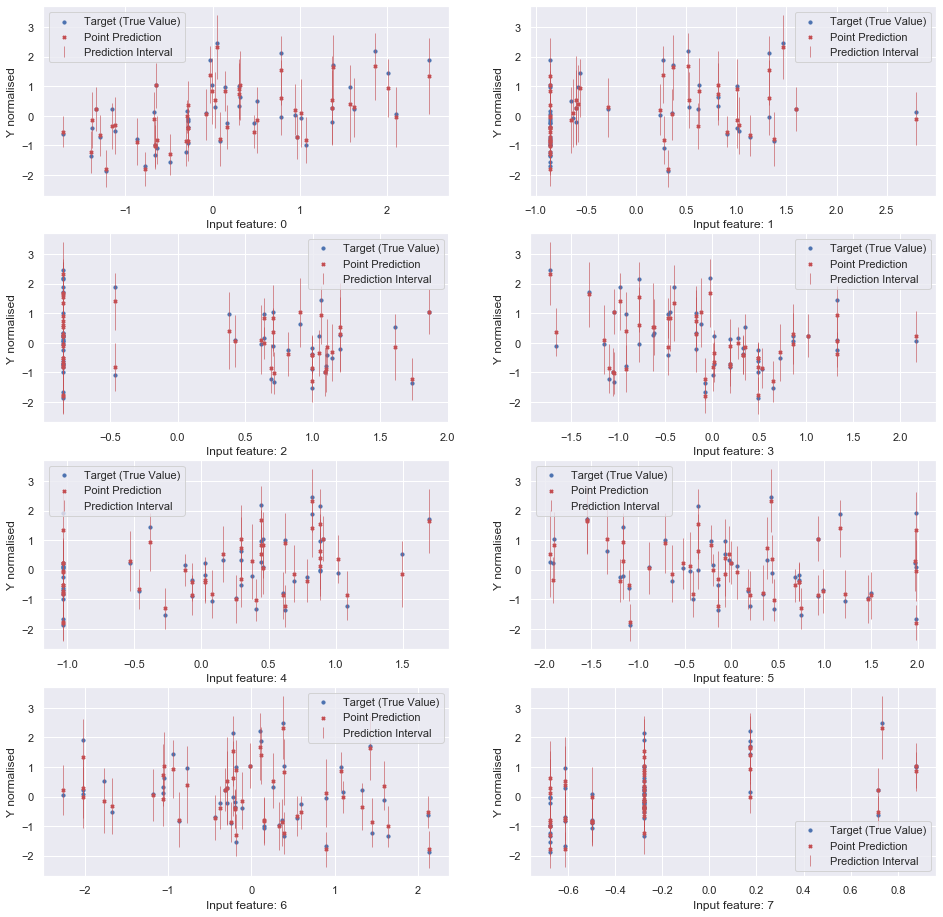

In [5]:
DATA_DIR="concrete"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]
weight_decay=1e-1/(TRAIN_SIZE+TEST_SIZE)**0.5

concrete_model= Dropout_Model(network=Dropout_Network(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS, 
                                             drop_prob=drop_prob),
                                   learn_rate=learn_rate, 
                                   weight_decay=weight_decay,
                                   y_scale=y_scale)

train_dropout(concrete_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR, model_name)
evaluate_model(concrete_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR, model_name)



## energy_heating_load

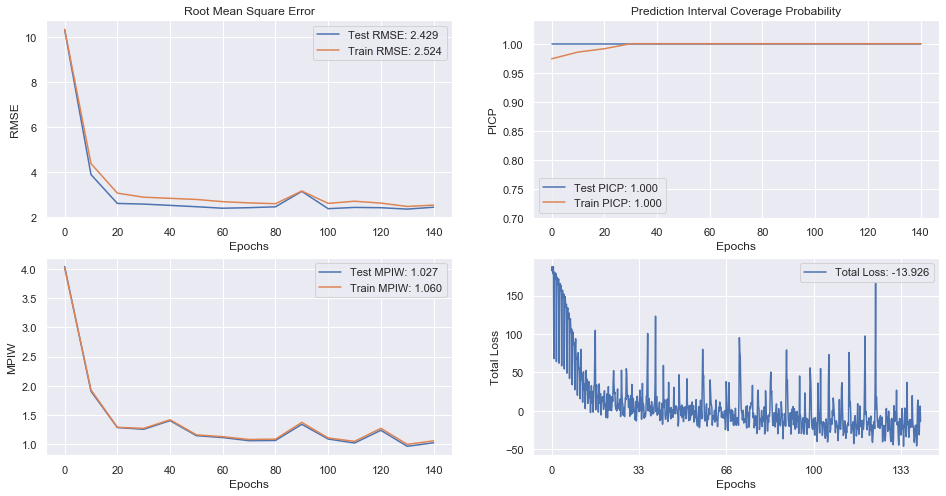

100%|██████████| 150/150 [00:17<00:00,  8.24it/s]


 RMSE = 2.280, PICP = 1.000, MPIW = 0.944


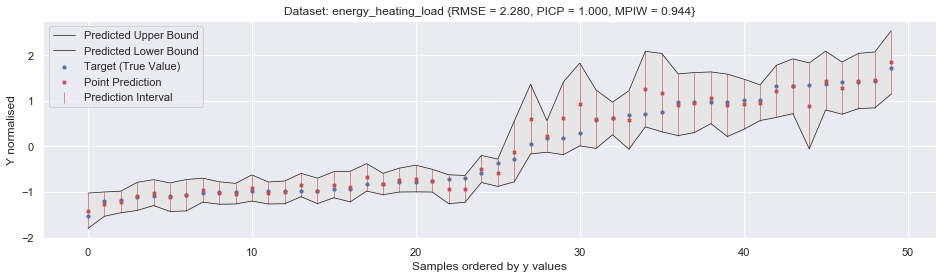

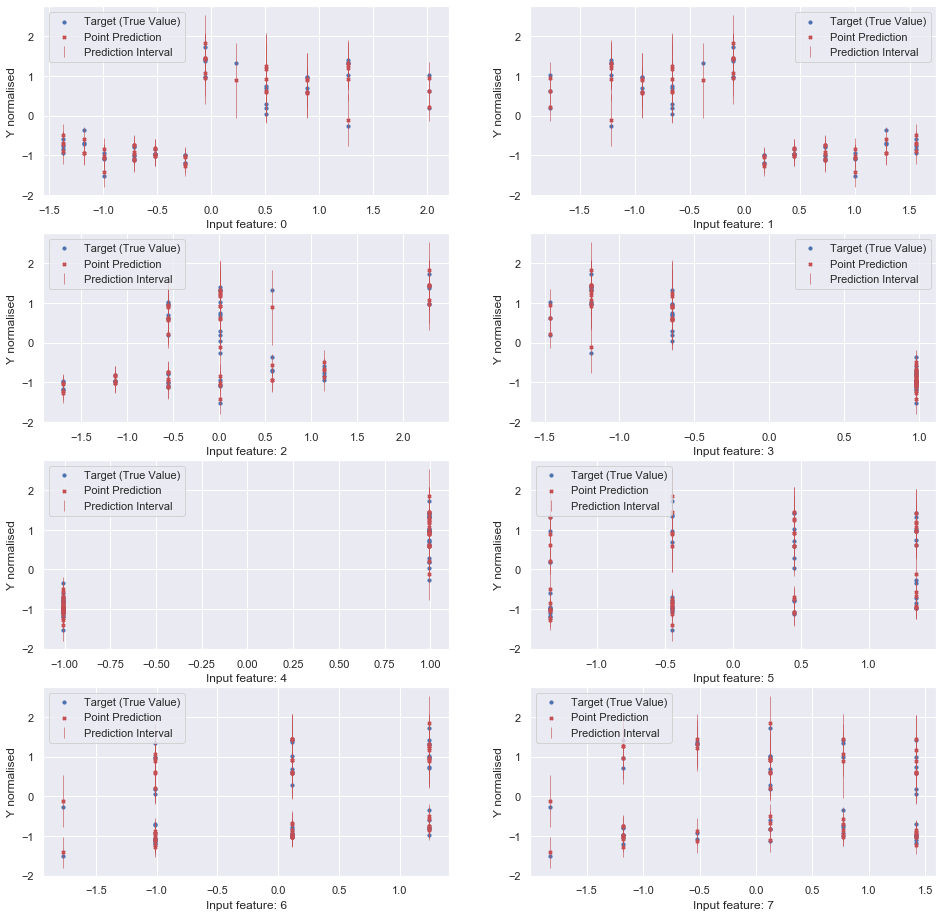

In [6]:
DATA_DIR="energy_heating_load"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]
weight_decay=1e-1/(TRAIN_SIZE+TEST_SIZE)**0.5

energy_model= Dropout_Model(network=Dropout_Network(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS, 
                                             drop_prob=drop_prob),
                                   learn_rate=learn_rate, 
                                   weight_decay=weight_decay,
                                   y_scale=y_scale)

train_dropout(energy_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR, model_name)
evaluate_model(energy_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR, model_name)



## kin8nm

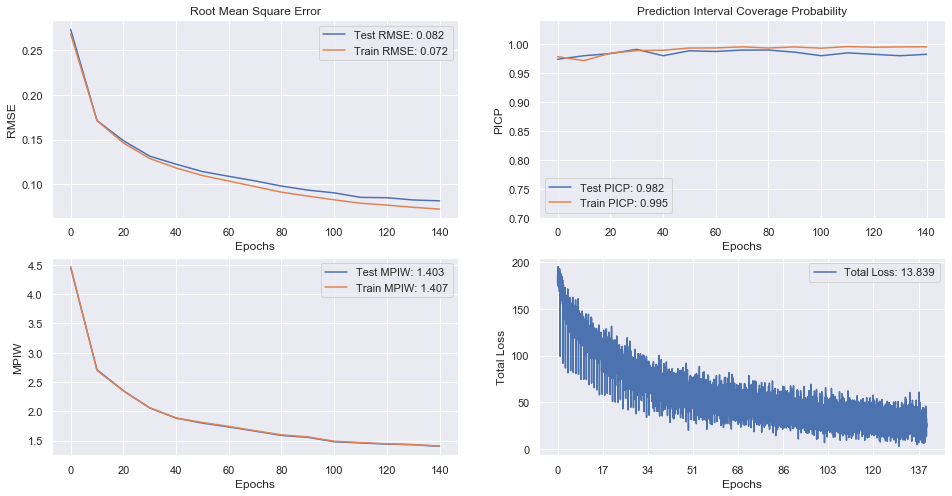

100%|██████████| 150/150 [00:55<00:00,  4.40it/s]


 RMSE = 0.079, PICP = 0.983, MPIW = 1.387


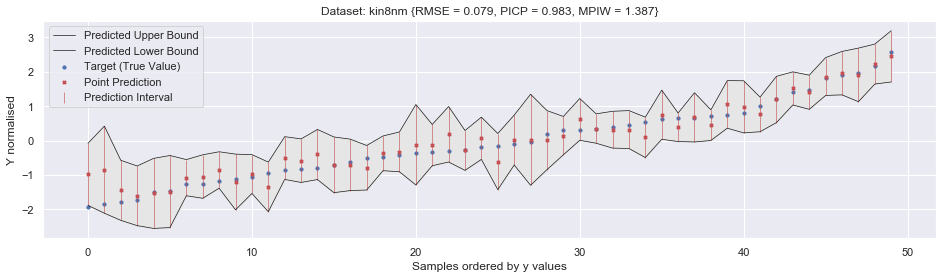

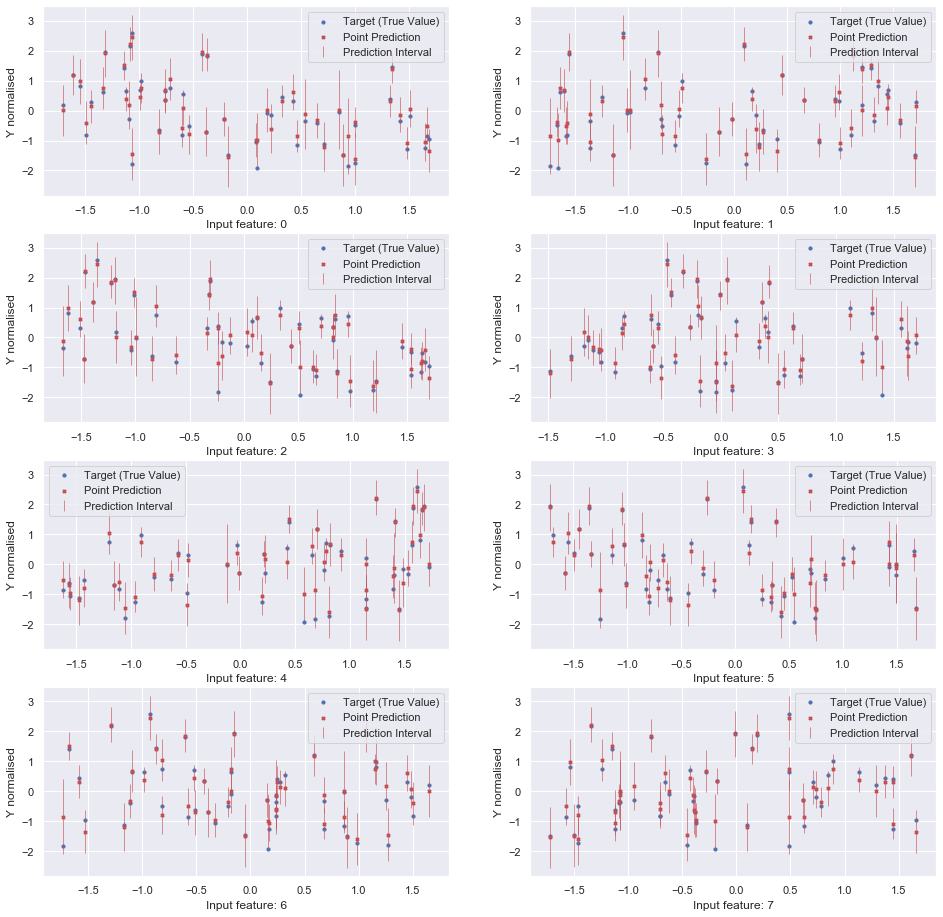

In [7]:
DATA_DIR="kin8nm"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]
weight_decay=1e-1/(TRAIN_SIZE+TEST_SIZE)**0.5

kin8nm_model= Dropout_Model(network=Dropout_Network(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS, 
                                             drop_prob=drop_prob),
                                   learn_rate=learn_rate, 
                                   weight_decay=weight_decay,
                                   y_scale=y_scale)

train_dropout(kin8nm_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR, model_name)
evaluate_model(kin8nm_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR, model_name)



## naval-propulsion-plant

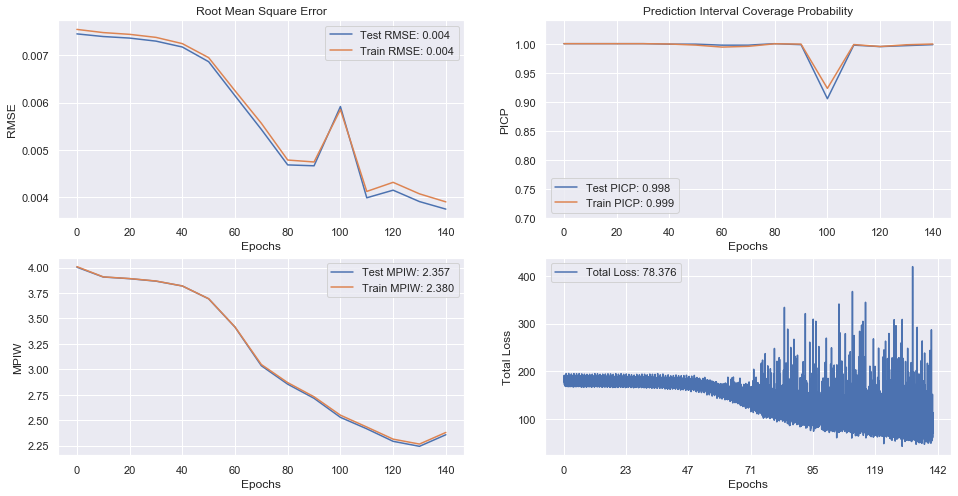

100%|██████████| 150/150 [01:14<00:00,  3.23it/s]


 RMSE = 0.004, PICP = 0.999, MPIW = 2.539


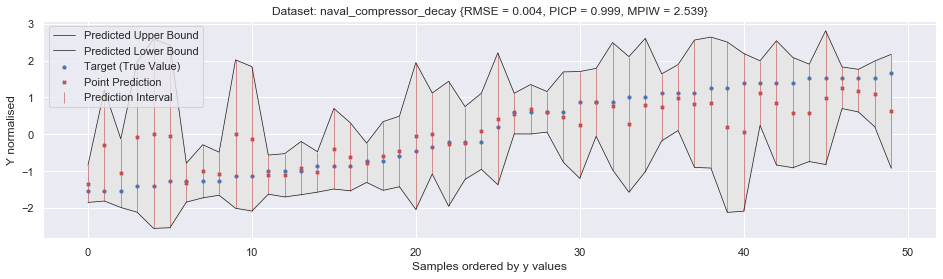

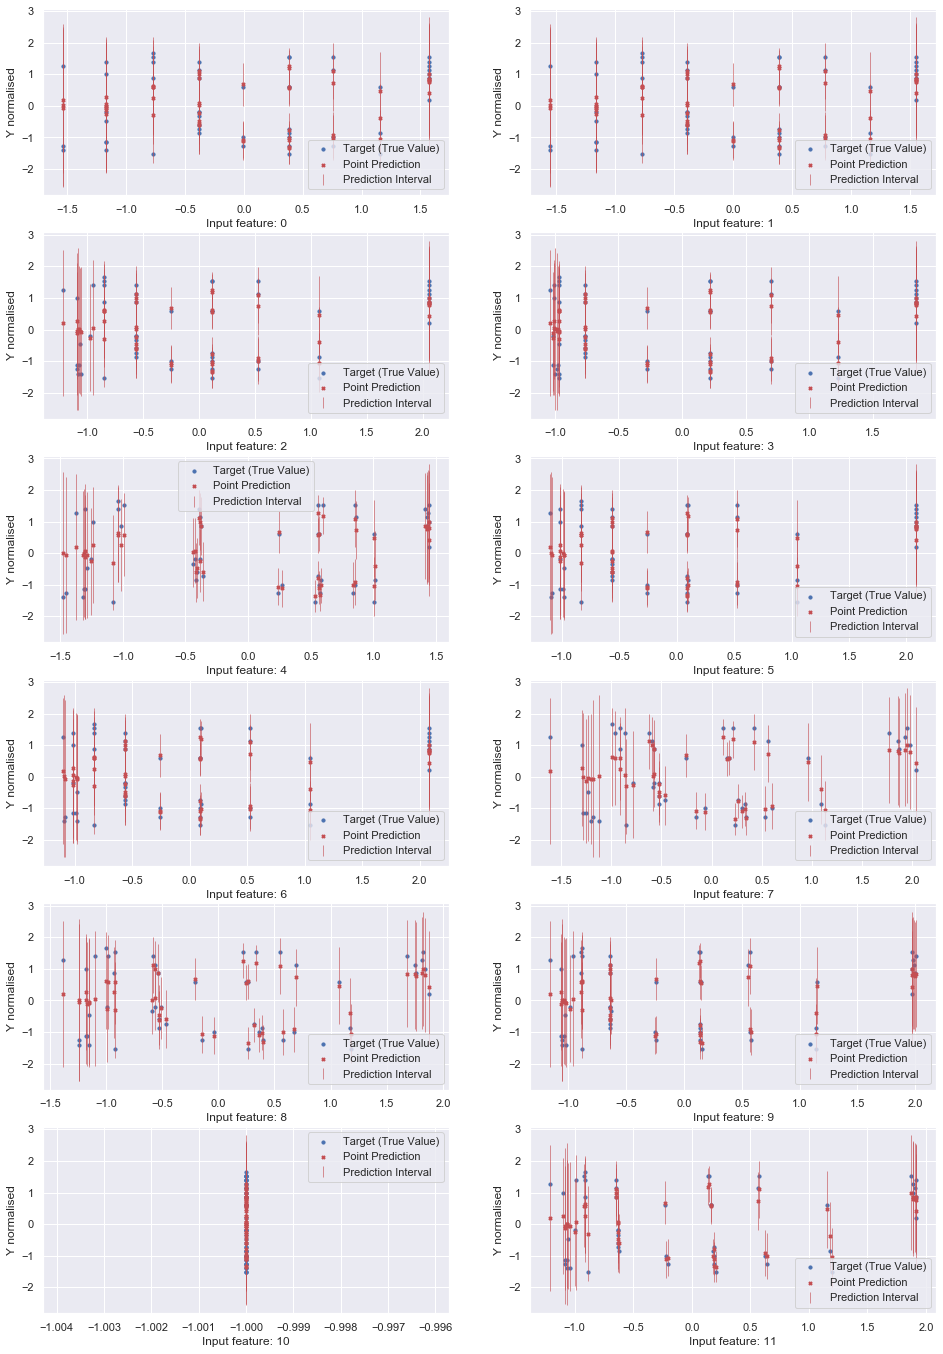

In [11]:
DATA_DIR="naval_compressor_decay"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]
weight_decay=1e-1/(TRAIN_SIZE+TEST_SIZE)**0.5

naval_model= Dropout_Model(network=Dropout_Network(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS, 
                                             drop_prob=drop_prob),
                                   learn_rate=learn_rate, 
                                   weight_decay=weight_decay,
                                   y_scale=y_scale)

train_dropout(naval_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR, model_name)
evaluate_model(naval_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR, model_name)



## power

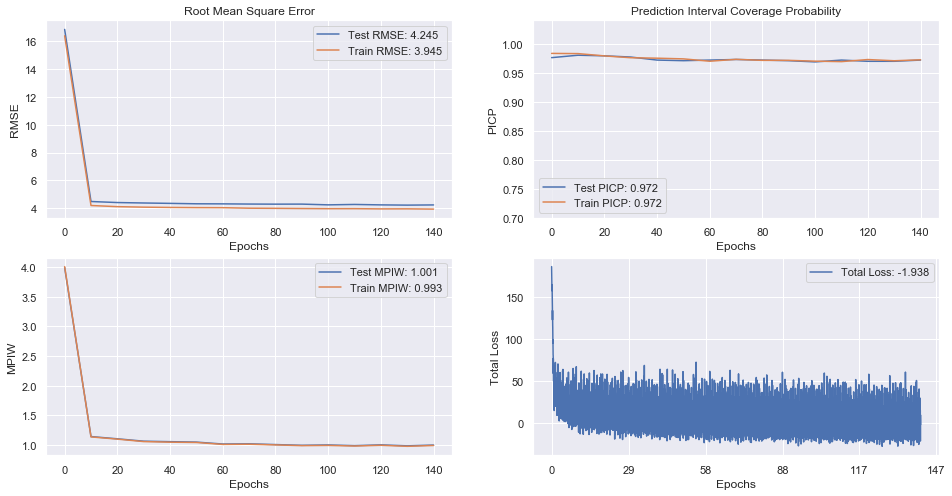

100%|██████████| 150/150 [01:01<00:00,  3.89it/s]


 RMSE = 4.214, PICP = 0.971, MPIW = 0.994


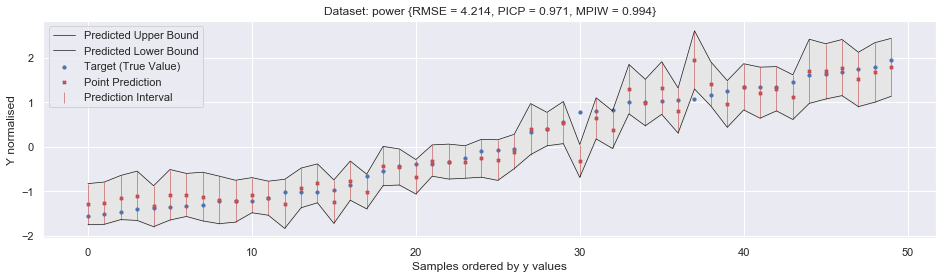

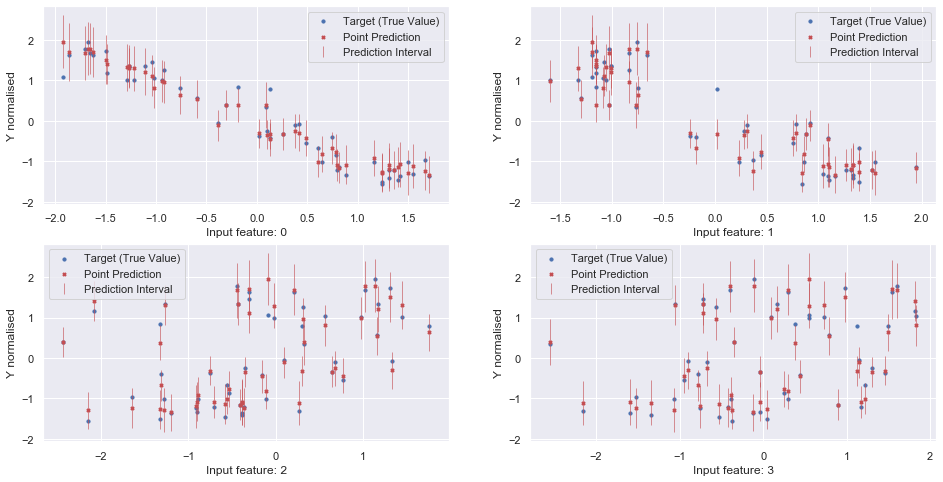

In [12]:
DATA_DIR="power"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]
weight_decay=1e-1/(TRAIN_SIZE+TEST_SIZE)**0.5

power_model= Dropout_Model(network=Dropout_Network(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS, 
                                             drop_prob=drop_prob),
                                   learn_rate=learn_rate, 
                                   weight_decay=weight_decay,
                                   y_scale=y_scale)

train_dropout(power_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every,DATA_DIR, model_name)
evaluate_model(power_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR, model_name)



## protein

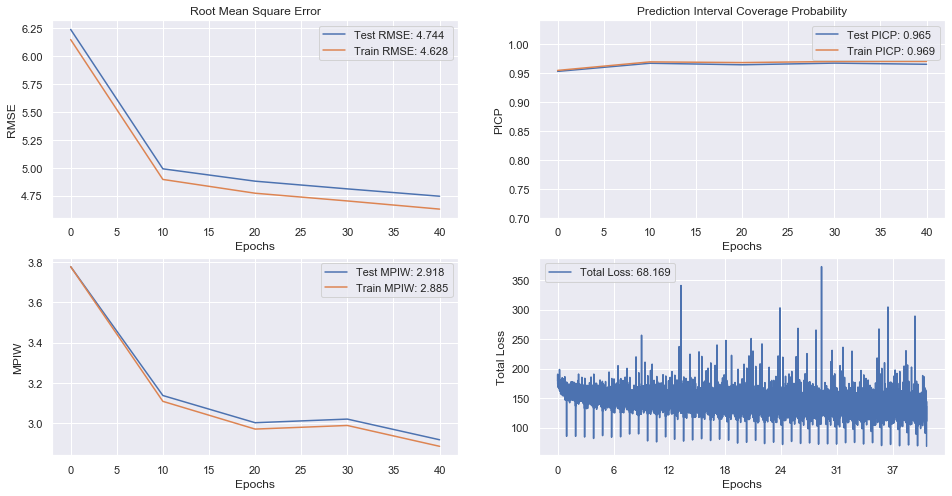

100%|██████████| 50/50 [01:11<00:00,  1.20s/it]


 RMSE = 4.694, PICP = 0.962, MPIW = 2.841


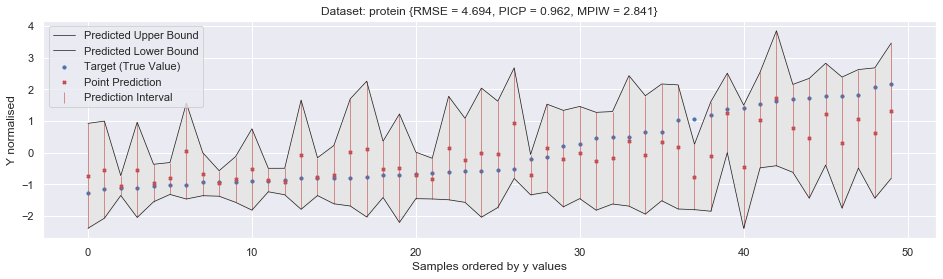

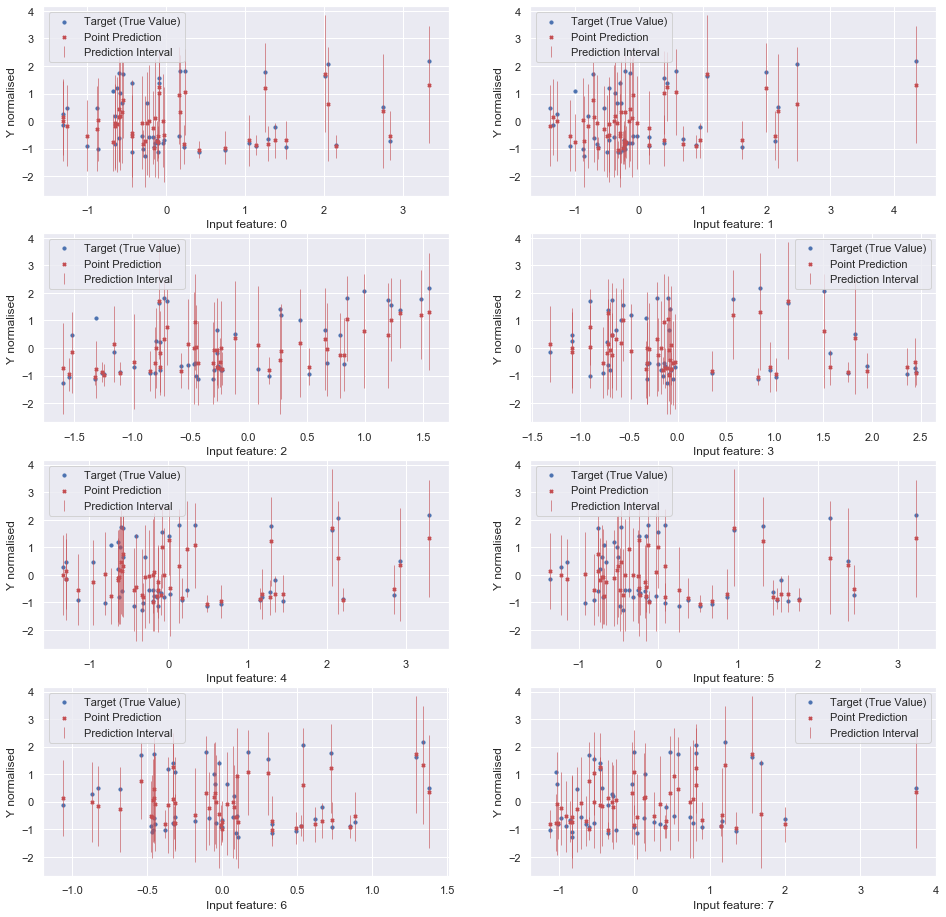

In [5]:
BATCH_SIZE =128 
TEST_BATCH_SIZE = 128
TRAIN_EPOCHS = 50
NUM_SAMPLES_TRAIN = 10
NUM_SAMPLES_TEST= 1000
OUTPUT_DIM = 1
NUM_UNITS = 100
GAMMA = 0.95
drop_prob=0.1
learn_rate=1e-4
log_every=10
model_name='Dropout_LL'


DATA_DIR="protein"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]
weight_decay=1e-1/(TRAIN_SIZE+TEST_SIZE)**0.5

protein_model= Dropout_Model(network=Dropout_Network(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS, 
                                             drop_prob=drop_prob),
                                   learn_rate=learn_rate, 
                                   weight_decay=weight_decay,
                                   y_scale=y_scale)

train_dropout(protein_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR, model_name)
evaluate_model(protein_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR, model_name)



## wine

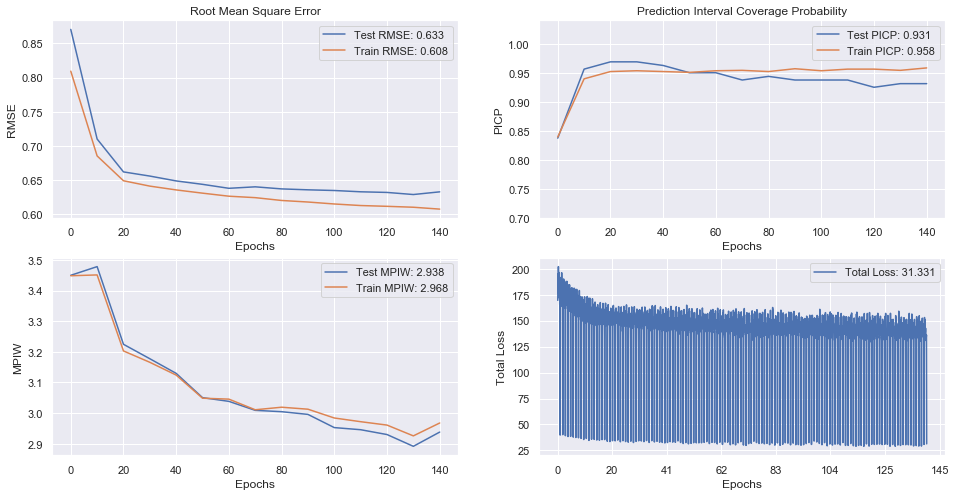

100%|██████████| 150/150 [00:21<00:00, 10.62it/s]


 RMSE = 0.631, PICP = 0.925, MPIW = 2.891


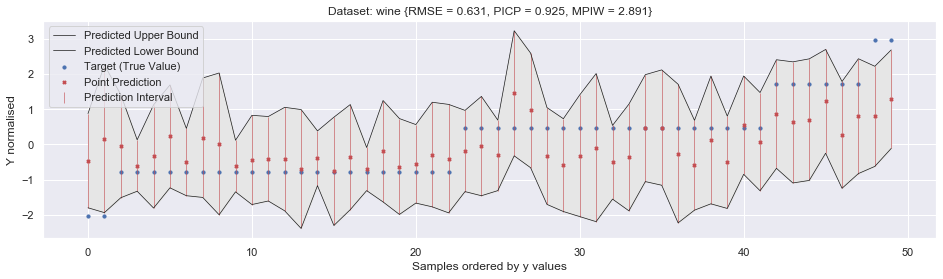

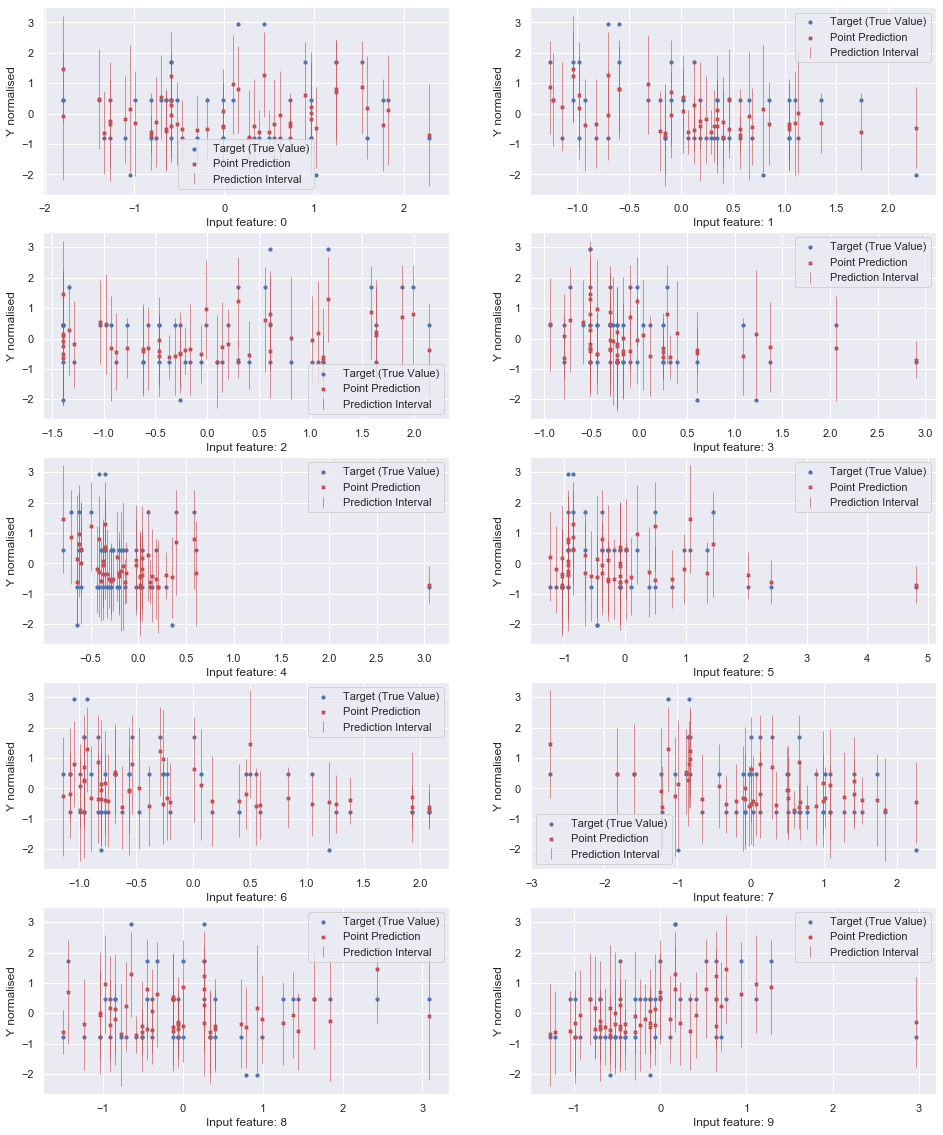

In [9]:
DATA_DIR="wine"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]
weight_decay=1e-1/(TRAIN_SIZE+TEST_SIZE)**0.5

wine_model= Dropout_Model(network=Dropout_Network(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS, 
                                             drop_prob=drop_prob),
                                   learn_rate=learn_rate, 
                                   weight_decay=weight_decay,
                                   y_scale=y_scale)

train_dropout(wine_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every, DATA_DIR, model_name)
evaluate_model(wine_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR, model_name)



## yacht

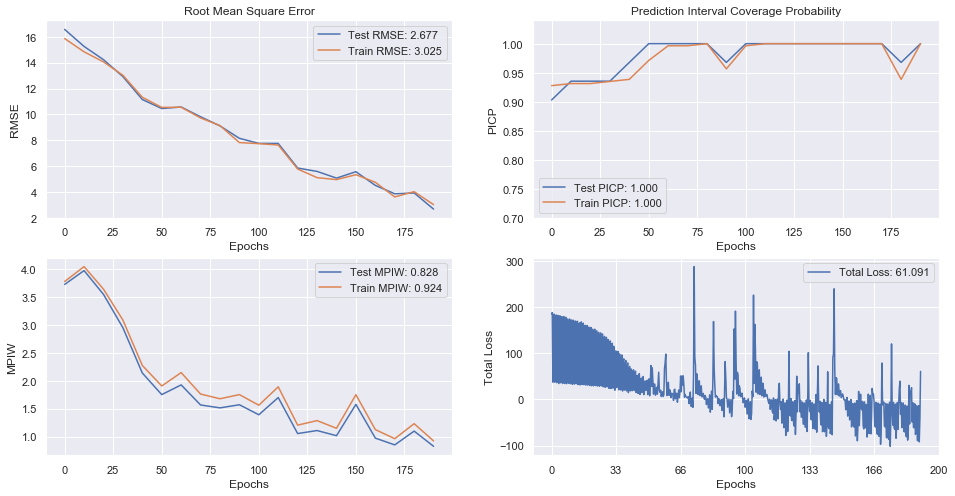

100%|██████████| 200/200 [00:35<00:00,  5.63it/s]


 RMSE = 3.052, PICP = 1.000, MPIW = 0.839


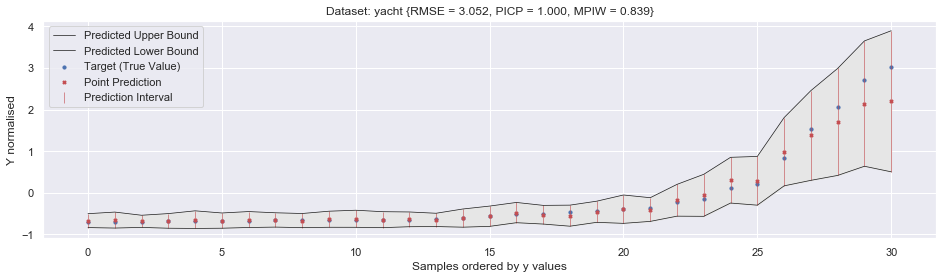

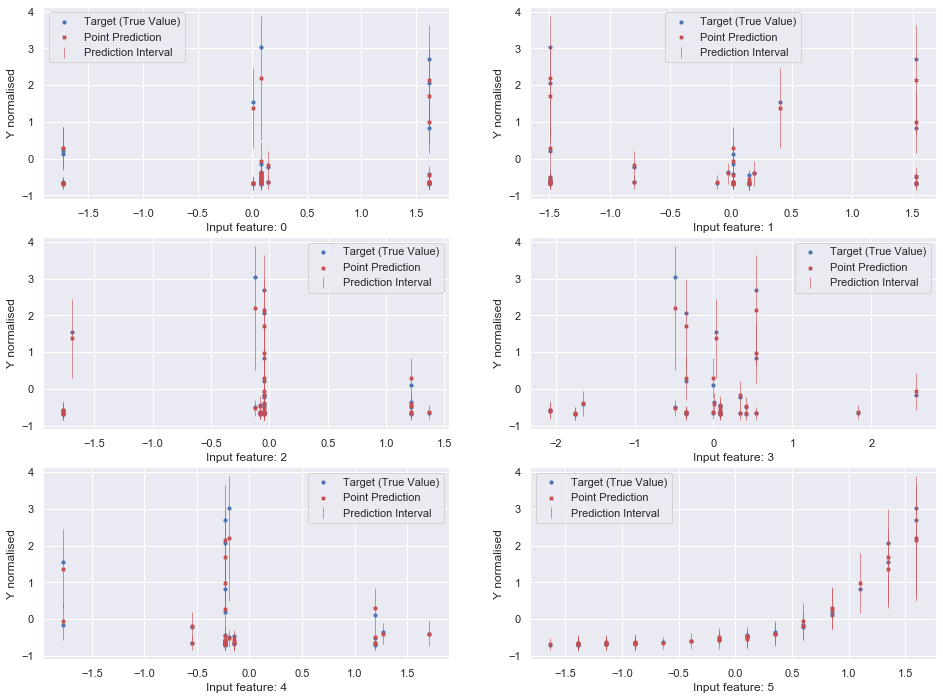

In [6]:

BATCH_SIZE =128 
TEST_BATCH_SIZE = 128
TRAIN_EPOCHS = 200
NUM_SAMPLES_TRAIN = 20
NUM_SAMPLES_TEST= 1000
OUTPUT_DIM = 1
NUM_UNITS = 100
GAMMA = 0.95
drop_prob=0.1
learn_rate=1e-4
log_every=10
model_name='Dropout_LL'



DATA_DIR="yacht"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]
weight_decay=1e-1/(TRAIN_SIZE+TEST_SIZE)**0.5

yacht_model= Dropout_Model(network=Dropout_Network(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS, 
                                             drop_prob=drop_prob),
                                   learn_rate=learn_rate, 
                                   weight_decay=weight_decay,
                                   y_scale=y_scale)

train_dropout(yacht_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every,DATA_DIR, model_name)
evaluate_model(yacht_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR, model_name)



## year

In [6]:
BATCH_SIZE =128 
TEST_BATCH_SIZE = 128
TRAIN_EPOCHS = 50
NUM_SAMPLES_TRAIN = 20
NUM_SAMPLES_TEST= 20
OUTPUT_DIM = 1
NUM_UNITS = 100
GAMMA = 0.95
drop_prob=0.1
learn_rate=1e-4
log_every=100
model_name='Dropout_LL'

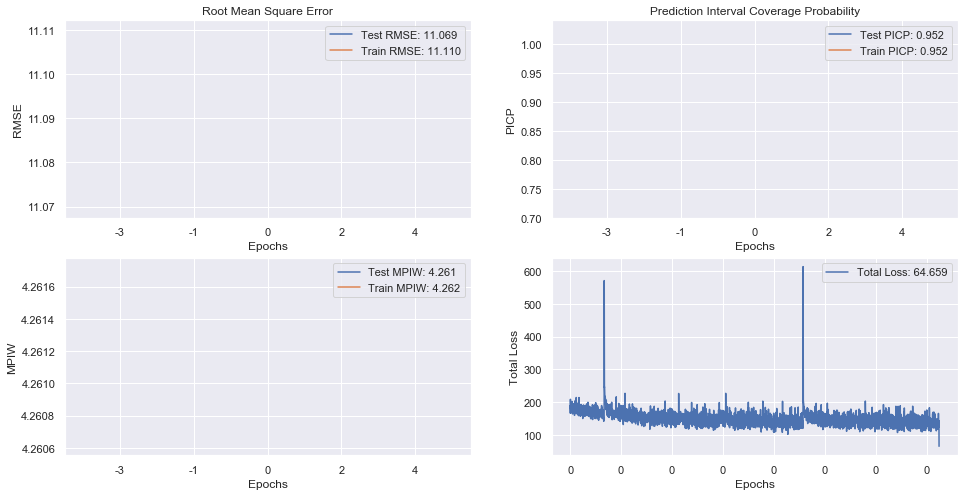

100%|██████████| 50/50 [12:27<00:00, 13.70s/it] 


 RMSE = 8.569, PICP = 0.950, MPIW = 2.652


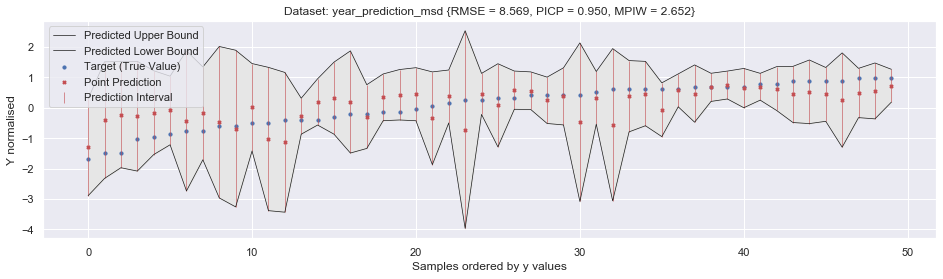

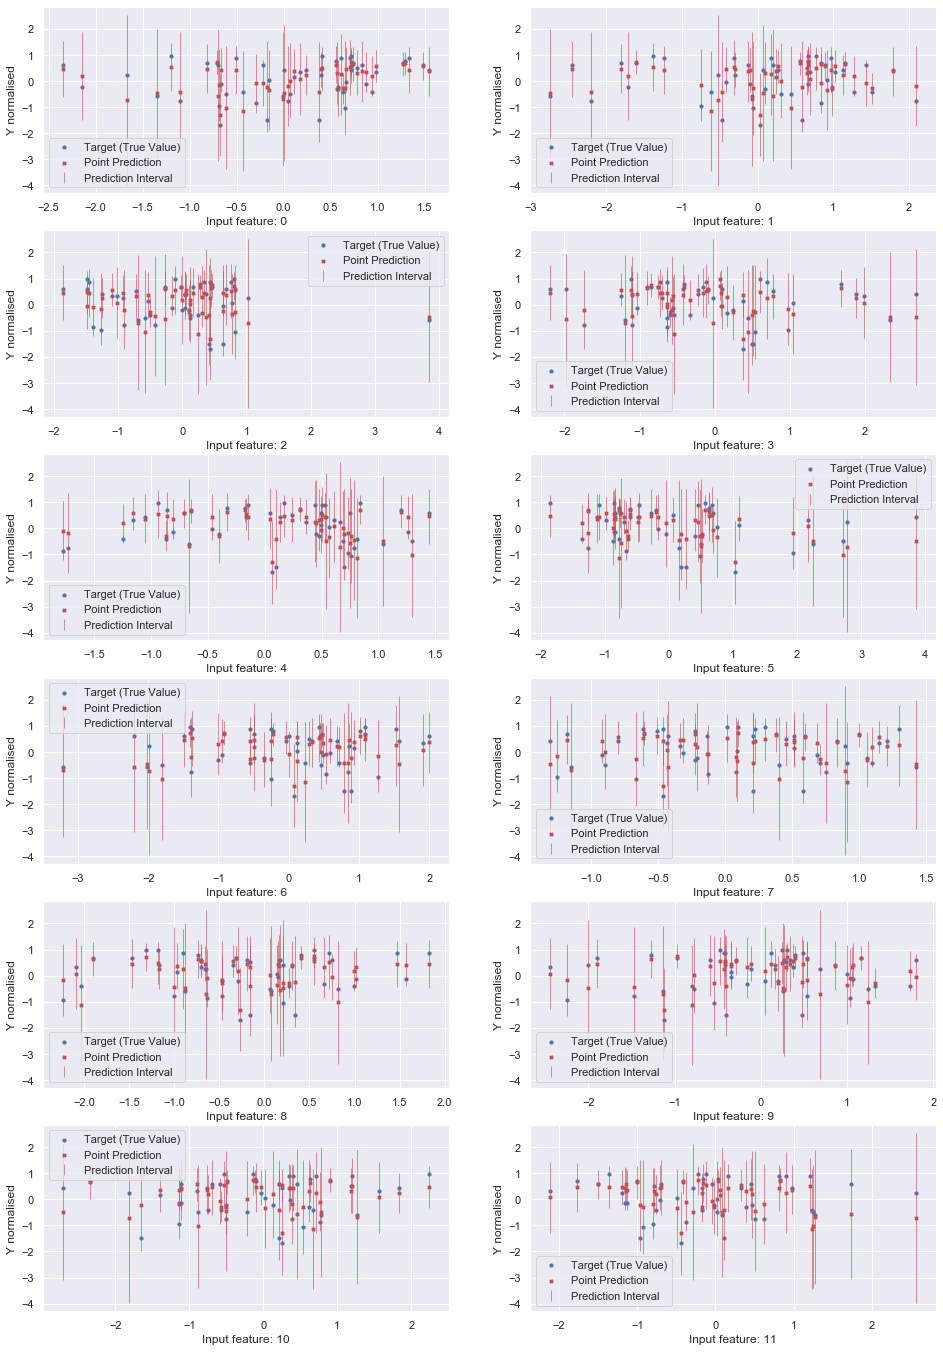

In [7]:
DATA_DIR="year_prediction_msd"

train_loader, test_loader, y_scale= load_normalize_data(data_dir=DATA_DIR,
                                                        train_batch_size=BATCH_SIZE,
                                                        test_batch_size=TEST_BATCH_SIZE)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

INPUT_DIM=train_loader.dataset.features.shape[-1]
weight_decay=1e-1/(TRAIN_SIZE+TEST_SIZE)**0.5

yacht_model= Dropout_Model(network=Dropout_Network(input_dim=INPUT_DIM, 
                                             output_dim=OUTPUT_DIM, 
                                             num_units=NUM_UNITS, 
                                             drop_prob=drop_prob),
                                   learn_rate=learn_rate, 
                                   weight_decay=weight_decay,
                                   y_scale=y_scale)

train_dropout(yacht_model,train_loader, test_loader,TRAIN_EPOCHS,NUM_SAMPLES_TRAIN,GAMMA, log_every,DATA_DIR, model_name)
evaluate_model(yacht_model, test_loader,NUM_SAMPLES_TEST,GAMMA, DATA_DIR, model_name)

